In [ ]:
# | default_exp eval

In [ ]:
# | export
import logging as l
from pathlib import Path

import torch

from looped_experiments.all import *
import looped_experiments.wandb_utils as wu
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# | export
class MetricsCB(Callback):
    def __init__(self, metric_fn): self.metric_fn = metric_fn
    def before_fit(self, _): self.metrics = []

    def after_batch(self, learn):
        self.metrics.append(to_cpu(self.metric_fn(learn.preds, learn.yb)))

    def after_epoch(self, learn):
        try:
            self.metrics = torch.cat(self.metrics)
        except TypeError:
            l.warning("Was not able to concatenate metrics")
            pass

In [ ]:
# | export
def squared_error(preds, ys):
    return (preds - ys).square()


def looped_error(preds, ys):
    # for lost tokens we take predictions from last loop the appeared in
    res = torch.zeros_like(preds[0])
    for pred in preds:
        res[~pred.isnan()] = pred[~pred.isnan()]
    return (res - ys).square()

In [ ]:
# | export
def eval(cfg, model_path=None):
    train = cfg.training
    task = get_task_cls(cfg.task.task_name)(train.batch_size, **cfg.task)
    dl_eval = dataloader(task, train.eval_steps)

    @FnCallback("before_batch")
    def trans_input(learner): learner.xb = (learner.xb, learner.yb)

    model = get_model(cfg.model)
    weights = torch.load(model_path or cfg.out_dir / "model_last.pt", weights_only=True)
    if '+train' in str(model_path): weights = weights['model_state_dict']
    model.load_state_dict(weights)
    loss_fn = get_loss(cfg.model)
    metric = looped_error if 'loop' in cfg.model.family else squared_error
    metric_cb = MetricsCB(metric)
    cbs = [ToDeviceCB(), trans_input, metric_cb]
    Learner(model, None, dl_eval, None, loss_fn=loss_fn, cbs=cbs).eval()
    return metric_cb.metrics

In [ ]:
eval_overrides = ["training.batch_size=256", "training.eval_steps=20", "task.n_points=41", "model.n_loops=100"]

## Get runs

In [ ]:
base = get_config()
# filter out runs that don't have a custom curriculum
filters = [lambda r: 'type' in r.config['model']['curriculum']['loops'],
           lambda r: '_k' not in r.name and '_short' not in r.name and r.name != "LR_loop_L1_ends{20}_T{5}_log"]
runs = wu.get_runs(base.wandb.project, wu.default_filters + filters)

In [ ]:
wu.refresh_models(runs.values())

Compute pointwise errors

In [ ]:
errs = {}
for k, v in runs.items():
    cfg = get_config(cfg_dict=v.config, overrides=eval_overrides + ['model.token_dec=0'])
    loc = Path("../" + v.config['out_dir'])
    loc = loc / 'model_last.pt' if (loc / 'model_last.pt').exists() else loc / 'model_90000+train.pt'
    errs[k] = eval(cfg, loc)

In [ ]:
# | export
def aggregate_metrics(result_dict, non_truncated_dims, bootstrap_trials=1000):
    """
    Takes as input a tensor of shape (num_eval, n_points) and returns a dict with
    per-point mean, stddev, and bootstrap limits
    """
    d = non_truncated_dims
    results = {}
    for model_name in result_dict.keys():
        errs = result_dict[model_name]
        tmp = {}
        tmp["mean"] = errs.mean(0) / d
        tmp["std"] = errs.std(0, unbiased=True) / d
        n = len(errs)
        bootstrap_indices = torch.randint(n, size=(bootstrap_trials, n))
        bootstrap_means = errs[bootstrap_indices].mean(dim=1).sort(dim=0)[0]
        tmp["bootstrap_low"] = bootstrap_means[int(0.05 * bootstrap_trials), :] / d
        tmp["bootstrap_high"] = bootstrap_means[int(0.95 * bootstrap_trials), :] / d
        results[model_name] = tmp

    return results

In [ ]:
res = aggregate_metrics(errs, cfg.task.n_dims)

In [ ]:
# |export
def plot_results(res, save=False):
    fig_hparam = {
        'figsize': (8, 5),
        'labelsize': 28,
        'ticksize': 20,
        'linewidth': 5,
        'fontsize': 15,
        'titlesize': 20,
        'markersize': 15
    }

    fig, ax = plt.subplots(1, figsize=fig_hparam['figsize'])

    cmap = plt.get_cmap("coolwarm")
    result_name_list = res.keys()
    colors = cmap(np.linspace(0, 1, len(result_name_list)))
    for idx, model_name in enumerate(result_name_list):
        err = res[model_name]["mean"]
        ax.plot(err, color=colors[idx], lw=fig_hparam['linewidth'], label=model_name.capitalize())
        low = res[model_name]["bootstrap_low"]
        high = res[model_name]["bootstrap_high"]
        ax.fill_between(range(len(low)), low, high, alpha=0.3, color=colors[idx])

    ax.tick_params(axis='both', labelsize=fig_hparam['ticksize'])
    ax.axhline(1, color='k', ls='--', lw=fig_hparam['linewidth'])
    # ax.set_ylim(-0.1, 1.25)
    # plt.xticks(np.arange(0, n_points))
    plt.rc('font', family='serif')
    ax.set_xlabel("in-context examples", fontsize=fig_hparam['labelsize'])
    y_label = ax.set_ylabel("squared error", fontsize=fig_hparam['labelsize'])
    legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fig_hparam['fontsize'])

    if save: plt.savefig("figure.png", dpi=600, bbox_inches='tight')

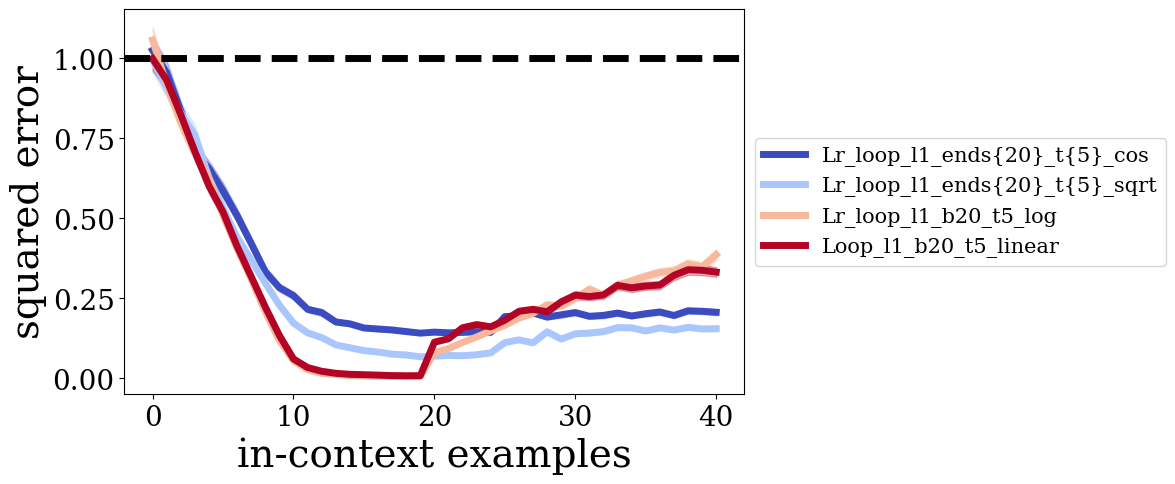

In [ ]:
plot_results(res)